In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch
import sys
from scipy.spatial.transform import Rotation as R
from argparse import ArgumentParser
import trimesh
from pytorch_lightning.loggers import TensorBoardLogger
from configargparse import ArgumentParser as ConfigArgumentParser
sys.path.insert(0, 'neural-head-avatars')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

2023-11-01 02:40:52.601631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 02:40:53.566126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-01 02:40:53.566243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-01 02:40:53.566253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
%cd neural-head-avatars

/home/dmitry/clones/PanoHead/neural-head-avatars


In [3]:
from nha.data.real import RealDataModule
from nha.models.nha_optimizer import NHAOptimizer, create_camera_objects
import pytorch_lightning as pl
from pytorch3d.structures import Meshes

In [9]:
optimizer_module = NHAOptimizer
data_module = RealDataModule

parser = ArgumentParser()
parser = optimizer_module.add_argparse_args(parser)
parser = data_module.add_argparse_args(parser)
parser = pl.Trainer.add_argparse_args(parser)

parser = ConfigArgumentParser(parents=[parser], add_help=False)
parser.add_argument('--config', required=True, is_config_file=True)
parser.add_argument("--checkpoint_file", type=str, required=False, default="",
                    help="checkpoint to load model from")

args = parser.parse_args([
    '--config', 'configs/optimize_avatar.ini',
    # DEBUG
    '--checkpoint_file', '/home/dmitry/clones/PanoHead/dataset/dmitry_result/lightning_logs/version_31/checkpoints/last.ckpt'
])
args_dict = vars(args)

# print(f"Start Model training with the following configuration: \n {parser.format_values()}")

# init datamodule
data = data_module(**args_dict)
data.setup()

# init optimizer
args_dict['max_frame_id'] = data.max_frame_id

if args.checkpoint_file:
    model = optimizer_module.load_from_checkpoint(args.checkpoint_file, strict=True, **args_dict)
else:
    model = optimizer_module(**args_dict)

/home/dmitry/.miniconda3/envs/nha/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: ModelCheckpoint(save_last=True, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  warnings.warn(*args, **kwargs)


In [10]:
train_loader = data.train_dataloader(2, shuffle=False)
sample = next(iter(train_loader))

In [11]:
flame_params_offsets = model._create_flame_param_batch(sample)
offsets_verts, pred_lmks = model._forward_flame(flame_params_offsets)

K = sample["cam_intrinsic"]
RT = sample["cam_extrinsic"]

H, W = sample["rgb"].shape[-2:]

# FILL SCENE
cameras = create_camera_objects(K, RT, (H, W), model.device)
flame_meshes = Meshes(verts=offsets_verts, faces=model._flame.faces[None].expand(len(offsets_verts), -1, -1))

raster_res = model._rasterize(flame_meshes, cameras, (H, W))
mesh_raster_res = model._rasterize(model._guidance_meshes.extend(2), cameras, (H, W), return_initial_fragments=True)


In [14]:
offsets_verts.shape, model._flame.faces.shape

(torch.Size([2, 16227, 3]), torch.Size([32392, 3]))

In [15]:
mesh = trimesh.Trimesh(
    vertices=offsets_verts[0].detach().cpu().numpy(),
    faces=model._flame.faces.cpu().numpy()
)
mesh.export('flame_broken_mouth.obj')

'# https://github.com/mikedh/trimesh\nv 0.15337008 -0.04337907 -0.03805811\nv 0.16199872 -0.04623270 -0.03529944\nv 0.16346630 -0.04276678 -0.03381844\nv 0.15516713 -0.04107931 -0.03695864\nv 0.18143454 -0.04200047 -0.05726749\nv 0.18414320 -0.03484663 -0.04535156\nv 0.18301077 -0.02921152 -0.04255292\nv 0.18250372 -0.02838060 -0.04963908\nv 0.08062716 -0.15748926 -0.25969818\nv 0.02310246 -0.15305527 -0.26977074\nv 0.02619215 -0.16375709 -0.25380617\nv 0.07417035 -0.17662907 -0.24019751\nv 0.10648531 -0.21714005 -0.15654029\nv 0.10269287 -0.19921373 -0.17925271\nv 0.08344260 -0.22555724 -0.17632994\nv 0.09909031 -0.23554406 -0.14825372\nv 0.09263466 0.07788709 0.19337590\nv 0.11053349 0.07552406 0.18009807\nv 0.10814828 0.06101412 0.18746127\nv -0.15788671 -0.04044929 -0.04354667\nv -0.16659848 -0.04321504 -0.04070049\nv -0.16812463 -0.03981698 -0.03961191\nv -0.15922680 -0.03799793 -0.04272155\nv -0.18536963 -0.03828481 -0.06459621\nv -0.18905751 -0.03097811 -0.05251787\nv -0.1881285

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


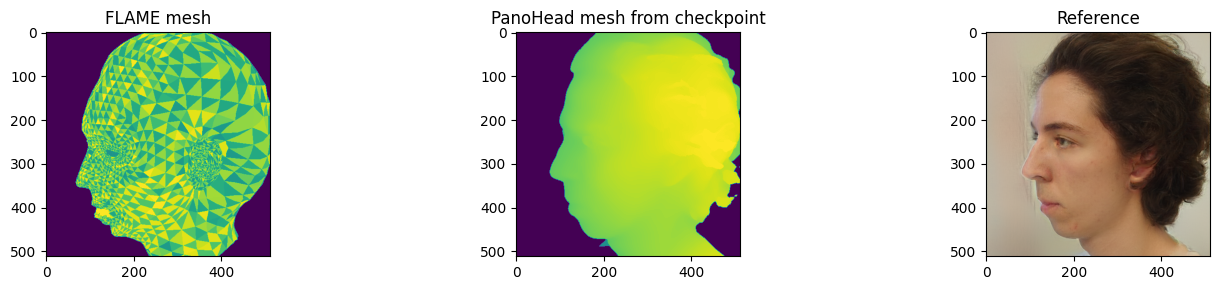

In [12]:
plt.figure(figsize=(15, 3))
idx = 1
plt.subplot(1, 3, 1)
plt.imshow(raster_res[0].pix_to_face[idx].detach().cpu().numpy())
plt.title("FLAME mesh")
plt.subplot(1, 3, 2)
plt.imshow(mesh_raster_res.pix_to_face[idx].detach().cpu().numpy()[..., 0])
plt.title("PanoHead mesh from checkpoint")
plt.subplot(1, 3, 3)
plt.imshow(sample['rgb'][idx].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title("Reference")

plt.tight_layout()

In [7]:
reference_path = "/home/dmitry/clones/PanoHead/pti_out/easy-khair-180-gpc0.8-trans10-025000.pkl/reference.npz"
reference = np.load(reference_path)

In [15]:
reference['image'].shape, reference['depth'].shape, reference['c'].shape

((2, 3, 512, 512), (2, 1, 64, 64), (2, 25))

In [33]:
reference['depth'].shape

(2, 1, 64, 64)

In [34]:
raster_res[0].zbuf.shape

torch.Size([2, 512, 512, 1])

In [30]:
raster_res[0].zbuf.min(), raster_res[0].zbuf.max()

(tensor(-1.), tensor(2.8573))

In [32]:
(reference['depth'] == reference['depth'].max()).sum()

818

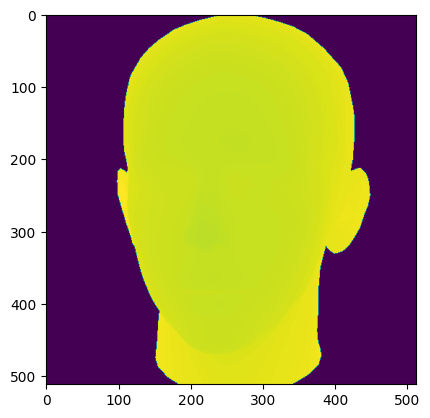

In [29]:
plt.imshow(raster_res[0].zbuf[0, ..., 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'PanoHead depth')

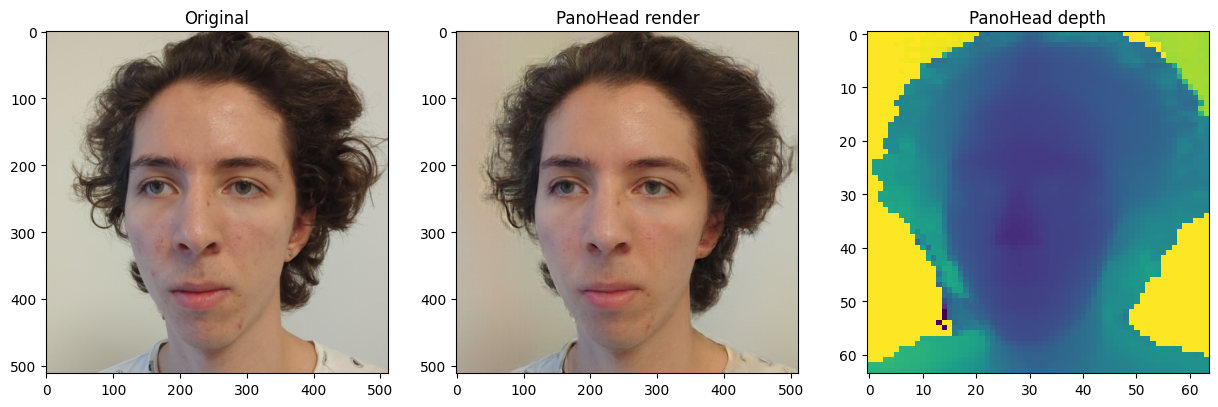

In [22]:
plt.figure(figsize=(15, 5))
idx = 0
plt.subplot(1, 3, 1)
plt.imshow(sample['rgb'][idx].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(reference['image'][idx].transpose(1, 2, 0) * 0.5 + 0.5)
plt.title("PanoHead render")
plt.subplot(1, 3, 3)
plt.imshow(reference['depth'][idx, 0])
plt.title("PanoHead depth")